In [ ]:
!python -m spacy download en_core_web_lg 

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=d66ce5a0e646ac80b9f419916136a825dcce13319d88a963fb69b1e69b140162
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3wn4dd4/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
!pip install jgraph

     |████████████████████████████████| 122kB 6.5MB/s 


In [ ]:
import pandas as pd
import networkx as nx
import random
import spacy
import en_core_web_lg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import lightgbm as lgb
import numpy as np
import jgraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
from sklearn.metrics.pairwise import pairwise_distances
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/MLNS/Kaggle/'

Mounted at /content/drive


In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
#loading training csv
training = pd.read_csv(path+'training_set.txt', 
                       sep = ' ', header = None) 

In [ ]:
#loading node information data and naming the columns

node_info = pd.read_csv(path+'node_information.csv', header= None)
node_info.columns = ['id', 'pub_year', 'title', 'authors', 'journal_name', 'abstract']
node_info = node_info.set_index('id')

In [ ]:
#creating the graph network - nodes and edges
IDs = [node_id for node_id in node_info.index]

training_list = training.values.tolist() # training dataframe convertion for easy edges list comprehension below
edges = [(node_pair[0], node_pair[1]) for node_pair in training_list if node_pair[2] == 1]

G = nx.DiGraph()
G.add_nodes_from(IDs)
G.add_edges_from(edges)

print("Number of nodes : " + str(G.number_of_nodes()))
print("Number of edges : " + str(G.number_of_edges()))

Number of nodes : 27770
Number of edges : 335130


## Training features

In [ ]:
#subsetting the training set to facilitate computation on laptop

training_reduced = training.sample(frac=0.1) # We keep 7%
training_reduced.columns = ['source', 'target', 'Y']

len(training_reduced)

61551

In [ ]:
# Degree Centrality features
out_degree_centrality = nx.out_degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
total_centrality = nx.degree_centrality(G)
training_reduced['source_out_centrality'] = training_reduced.apply(lambda row: out_degree_centrality[row.source],axis=1)
training_reduced['target_in_centrality'] = training_reduced.apply(lambda row: in_degree_centrality[row.target],axis=1)
training_reduced['source_centrality'] = training_reduced.apply(lambda row: total_centrality[row.source],axis=1)
training_reduced['target_centrality'] = training_reduced.apply(lambda row: total_centrality[row.target],axis=1)

In [ ]:
eigen_centrality = nx.eigenvector_centrality(G)
training_reduced['source_evc'] = training_reduced.apply(lambda row: eigen_centrality[row.source],axis=1)
training_reduced['target_evc'] = training_reduced.apply(lambda row: eigen_centrality[row.target],axis=1)

In [ ]:
# Page rank
page_rank = nx.pagerank_scipy(G)
training_reduced['target_pagerank'] = training_reduced.apply(lambda row: page_rank[row.target],axis=1)

# Preferential Attachment
# For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
training_reduced['preferencial_attachment'] = training_reduced.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)

# HITS algorithm
hub_score, authority_score = nx.hits(G)
training_reduced['source_hub_score'] = training_reduced.apply(lambda row: hub_score[row.source],axis=1)
training_reduced['target_authority_score'] = training_reduced.apply(lambda row: authority_score[row.target],axis=1)

In [ ]:
#feature engineering on node attributes - based on node information like title, abstract, published date

#difference in publication year

training_reduced['pub_year_difference'] = training_reduced.apply(lambda row: node_info.pub_year[row.source] - node_info.pub_year[row.target] ,axis=1)
training_reduced['pub_year_difference']=training_reduced['pub_year_difference'].where(training_reduced['pub_year_difference'] >= 0, -1)

# common Authors
node_info['authors'] = node_info['authors'].fillna(value='')
training_reduced['common_authors'] = training_reduced.apply(lambda row: len(set(node_info.authors[row.source].split(",")).intersection(set(node_info.authors[row.target].split(",")))) ,axis=1)

#number of common journal name
node_info['journal_name'] = node_info['journal_name'].fillna(value='')
training_reduced['common_journals'] = training_reduced.apply(lambda row: len(set(node_info.journal_name[row.source]).intersection(set(node_info.journal_name[row.target]))) ,axis=1)

In [ ]:
# Title similarity-spacy
training_reduced['title_similarity'] = training_reduced.apply(lambda row: nlp(node_info.title[row.source]).similarity(nlp(node_info.title[row.target])) ,axis=1)

# Abstract similarity- spacy
training_reduced['abstract_similarity'] = training_reduced.apply(lambda row: nlp(node_info.abstract[row.source]).similarity(nlp(node_info.abstract[row.target])) ,axis=1)

/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__mai

In [ ]:
#cosine distance of abstracts - tf-idf


nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()



def tfidf_abstract():

    tfidf_abstracts = []

    for i in range(len(node_info)):
        abstract = node_info.iloc[i]['abstract'].lower().split(" ")
        abstract = [token for token in abstract if token not in stpwds]
        abstract = [stemmer.stem(token) for token in abstract]
        tfidf_abstracts.append(" ".join(abstract))

    vectorizer = TfidfVectorizer(min_df=2)
    tfidf_abstracts = vectorizer.fit_transform(tfidf_abstracts)

    tfidf_abstracts = tfidf_abstracts.toarray()

    return tfidf_abstracts

tfidf_abstracts = tfidf_abstract()


training_distance_abs = []
    
for i in range(len(training_reduced)):
    source = training_reduced.iloc[i]['source']
    target = training_reduced.iloc[i]['target']

    index_source = IDs.index(source)
    index_target = IDs.index(target)

    source_info = tfidf_abstracts[index_source].reshape(1, -1)
    target_info = tfidf_abstracts[index_target].reshape(1, -1)

    training_distance_abs.append(pairwise_distances(source_info, target_info, metric='cosine', n_jobs=1))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
training_distance_abs2 = (np.asarray(training_distance_abs).reshape(len(training_reduced),1)).tolist()
training_distance_abs = [val for sublist in training_distance_abs2 for val in sublist]
training_reduced['training_dist_abs']=training_distance_abs

In [ ]:
#coside distance for titles - tf-idf

def tfidf_title():

    tfidf_title = []

    for i in range(len(node_info)):
        title = node_info.iloc[i]['title'].lower().split(" ")
        title = [token for token in title if token not in stpwds]
        title = [stemmer.stem(token) for token in title]
        tfidf_title.append(" ".join(title))

    vectorizer = TfidfVectorizer(min_df=2)
    tfidf_title = vectorizer.fit_transform(tfidf_title)

    tfidf_title = tfidf_title.toarray()

    return tfidf_title

tfidf_title = tfidf_title()


training_distance_title = []
    
for i in range(len(training_reduced)):
    source = training_reduced.iloc[i]['source']
    target = training_reduced.iloc[i]['target']

    index_source = IDs.index(source)
    index_target = IDs.index(target)

    source_info = tfidf_title[index_source].reshape(1, -1)
    target_info = tfidf_title[index_target].reshape(1, -1)

    training_distance_title.append(pairwise_distances(source_info, target_info, metric='cosine', n_jobs=1))

In [ ]:
training_distance_title2=(np.asarray(training_distance_title).reshape(len(training_reduced),1)).tolist()
training_distance_title = [val for sublist in training_distance_title2 for val in sublist]
training_reduced['training_dist_title']=training_distance_title

In [ ]:
training_reduced

In [ ]:
from collections import defaultdict

out = defaultdict(list)
inc = defaultdict(list)
for i, j in edges:
    out[i].append(j)
    inc[j].append(i)

In [ ]:
def jaccard(source, target):
    try:
        denom = 1/len(set(out[source]) | set(inc[target]))
    except:
        denom = 1
    jac = len(set(out[source]) & set(inc[target]))*denom
    return jac

In [ ]:

def comonneighbors(source, target):
    source = set(out[source]) | set(inc[source])
    target = set(out[target]) | set(inc[target])
    return len(target & source)

In [ ]:
#jaccard

ls=[]
for i in range(training_reduced.shape[0]):
    ls.append(jaccard(training_reduced.iloc[i]['source'], training_reduced.iloc[i]['target']))
training_reduced['jacard'] = ls

In [ ]:
#common neighbors

ls = [] 
for i in range(training_reduced.shape[0]):
    ls.append(comonneighbors(training_reduced.iloc[i]['source'], training_reduced.iloc[i]['target']))
training_reduced['comonneigh'] = ls

In [ ]:
#in neighbors
#out neighbors

ls1=[]
ls2=[]
for i in range(training_reduced.shape[0]):
    ls1.append(len(out[training_reduced.iloc[i]['source']]))
    ls2.append(len(inc[training_reduced.iloc[i]['target']]))
training_reduced['outneighbors'] = ls1
training_reduced['inneighbors'] = ls2

In [ ]:
#common successors
ls=[]
for i, rows in training_reduced.iterrows():
    ls.append(len(set(out[rows['source']]) & set(out[rows['target']])))
training_reduced['common_successors'] = ls

In [ ]:
#common predessesors
ls=[]
for i, rows in training_reduced.iterrows():
    ls.append(len(set(inc[rows['source']]) & set(inc[rows['target']])))
training_reduced['common_pred'] = ls

In [ ]:
#number of overlapping words in title
def overlapping_title(source, target):
    title = node_info.loc[source, 'title']
    title = [token for token in title.lower().split(" ") if token not in stpwds]
    source = [stemmer.stem(token) for token in title]
    title = node_info.loc[target, 'title']
    title = [token for token in title.lower().split(" ") if token not in stpwds]
    target = [stemmer.stem(token) for token in title]    
    return len(set(target) & set(source))
ls=[]
for i, rows in training_reduced.iterrows():
    ls.append(overlapping_title(rows['source'], rows['target']))

training_reduced['overlap_title'] = ls

In [ ]:
#number of overlapping words( >= 9 letters) in abstracts
def overlapping_abstract(source, target):
    abstract = node_info.loc[source, 'abstract']
    abstract = [token for token in abstract.lower().split(" ") if token not in stpwds and len(token)>8]
    source = [stemmer.stem(token) for token in abstract]
    abstract = node_info.loc[target, 'abstract']
    abstract = [token for token in abstract.lower().split(" ") if token not in stpwds and len(token)>8]
    target = [stemmer.stem(token) for token in abstract]    
    return len(set(target) & set(source))
ls=[]
for i, rows in training_reduced.iterrows():
    ls.append(overlapping_abstract(rows['source'], rows['target']))

training_reduced['overlap_abstract'] = ls

In [ ]:
#paths of length one
ls=[]
for i, rows in training_reduced.iterrows():
    try:
        short_path = nx.shortest_path_length(G,source=rows['source'],target=rows['target'])
    except:
        short_path = -1
    ls.append(short_path)
training_reduced['short_path'] = ls

In [ ]:

#popularity
ls=[]
for i, rows in training_reduced.iterrows():
    ls.append(sum([len(inc[in_target]) for in_target in inc[rows['target']]]))
training_reduced['popularity'] = ls

In [ ]:
#loading node information data and naming the columns
node_info = pd.read_csv(path+'node_information.csv', header= None)
node_info.columns = ['id', 'pub_year', 'title', 'authors', 'journal_name', 'abstract']
node_info = node_info.set_index('id')

#creating the graph network - nodes and edges
IDs = [node_id for node_id in node_info.index]

training_list = training.values.tolist() # training dataframe convertion for easy edges list comprehension below
edges = [(node_pair[0], node_pair[1]) for node_pair in training_list if node_pair[2] == 1]

G = nx.DiGraph()
G.add_nodes_from(IDs)
G.add_edges_from(edges)

print("Number of nodes : " + str(G.number_of_nodes()))
print("Number of edges : " + str(G.number_of_edges()))

Number of nodes : 27770
Number of edges : 335130


In [ ]:
# Preferential attachement
La = list(G.degree(training_reduced['target']))
Lb = list(G.degree(training_reduced['target']))

PA = [a[1]*b[1] for a,b in zip(La,Lb)]
training_reduced['PA'] = PA



In [ ]:
#AdamicAdar
G_prime = G.to_undirected()
AdamicAdar = []

for i in range(len(training_reduced)):
  #  print(i)
    inter_list = nx.common_neighbors(G_prime, training_reduced['source'][i], training_reduced['target'][i])
    AdamicAdar.append(sum( [1/np.log(G_prime.degree(node)) for node in inter_list]))

training_reduced['AdamicAdar'] = AdamicAdar


#Standardize values if needed
training_reduced['AA_std'] = (training_reduced['AdamicAdar']-training_reduced['AdamicAdar'].mean())/training_reduced['AdamicAdar'].std()


In [ ]:
nx.common_neighbors(G_prime, training_reduced['source'][0], training_reduced['target'][0])

In [ ]:
training_reduced

,source,target,Y,source_out_centrality,target_in_centrality,source_centrality,target_centrality,source_evc,target_evc,target_pagerank,preferencial_attachment,source_hub_score,target_authority_score,pub_year_difference,common_authors,common_journals,title_similarity,abstract_similarity,training_dist_abs,training_dist_title,jacard,comonneigh,outneighbors,inneighbors,common_successors,common_pred,overlap_title,overlap_abstract,short_path,popularity,PA,AdamicAdar,AA_std
0,201268,106086,1,0.001008,0.000756,0.001332,0.001873,3.225356e-10,2.160483e-08,0.000021,7.625298e-07,4.162079e-05,0.000132,1,0,8,0.599307,0.932746,0.698262,0.830163,0.088889,15,28,21,9,2,1,1,1,291,2704,3.383829,0.623655
1,303245,9912249,1,0.000972,0.006950,0.000972,0.007670,2.216651e-38,6.815509e-07,0.000219,6.757726e-06,8.724021e-06,0.000318,4,0,0,0.588809,0.943256,0.953734,1.000000,0.028037,6,27,193,0,0,0,0,1,5550,45369,1.218342,-0.094395
2,103047,9803167,1,0.001368,0.002017,0.001404,0.003637,1.349280e-22,3.696475e-04,0.000074,2.759632e-06,3.389136e-04,0.000566,3,0,9,0.714307,0.927827,0.961005,0.882550,0.056180,12,38,56,7,0,1,0,1,2494,10201,2.295006,0.262614
3,9708168,9903201,0,0.002341,0.000396,0.003025,0.000756,2.487611e-05,4.310256e-06,0.000019,9.272259e-07,1.203392e-04,0.000075,-1,0,6,0.511467,0.968647,0.868493,0.964800,0.000000,0,65,11,0,0,1,1,9,292,441,0.000000,-0.498383
4,9211108,9811043,0,0.000000,0.000000,0.000180,0.000072,1.993640e-05,2.216651e-38,0.000011,0.000000e+00,0.000000e+00,0.000000,-1,0,1,0.498692,0.942453,0.971903,1.000000,0.000000,0,0,0,0,0,0,2,-1,0,4,0.000000,-0.498383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61546,9610004,9607110,0,0.000072,0.000396,0.000072,0.000396,2.216651e-38,7.113873e-07,0.000030,2.853003e-08,1.970745e-15,0.000019,0,0,0,0.278649,0.882433,0.967820,1.000000,0.000000,0,2,11,0,0,0,0,-1,45,121,0.000000,-0.498383
61547,9902137,9601066,0,0.000324,0.000000,0.000864,0.000036,2.858195e-07,2.216651e-38,0.000011,0.000000e+00,2.431998e-04,0.000000,3,0,0,0.665011,0.949547,0.967451,1.000000,0.000000,0,9,0,0,0,0,0,-1,0,1,0.000000,-0.498383
61548,9806146,9602064,1,0.001440,0.006194,0.005654,0.007202,1.510618e-05,1.086430e-02,0.000546,8.922118e-06,3.059135e-04,0.000744,2,0,1,0.661409,0.965964,0.695576,1.000000,0.000000,7,40,172,5,2,0,3,1,9010,40000,1.232788,-0.089605
61549,211236,9205110,1,0.001152,0.001188,0.001693,0.001188,2.031627e-21,3.504871e-04,0.000055,1.369441e-06,2.895063e-05,0.000044,10,0,0,0.913034,0.950249,0.930183,0.607162,0.065574,5,32,33,0,1,2,1,1,783,1089,1.319043,-0.061004


In [ ]:
training_reduced.to_csv(path+'training_reduced_10percent.csv')

## Processing on testing set

In [ ]:

testing = pd.read_csv(path+'testing_set.txt', sep = ' ', header = None)
testing.columns = ['source', 'target']

In [ ]:

# Degree Centrality features
out_degree_centrality = nx.out_degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
total_centrality = nx.degree_centrality(G)
testing['source_out_centrality'] = testing.apply(lambda row: out_degree_centrality[row.source],axis=1)
testing['target_in_centrality'] = testing.apply(lambda row: in_degree_centrality[row.target],axis=1)
testing['source_centrality'] = testing.apply(lambda row: total_centrality[row.source],axis=1)
testing['target_centrality'] = testing.apply(lambda row: total_centrality[row.target],axis=1)

In [ ]:
#eigen vector centrality
eigen_centrality = nx.eigenvector_centrality(G)
testing['source_evc'] = testing.apply(lambda row: eigen_centrality[row.source],axis=1)
testing['target_evc'] = testing.apply(lambda row: eigen_centrality[row.target],axis=1)

In [ ]:
# Page rank
page_rank = nx.pagerank_scipy(G)
testing['target_pagerank'] = testing.apply(lambda row: page_rank[row.target],axis=1)

# Preferential Attachment
# For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
testing['preferencial_attachment'] = testing.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)

# HITS algorithm
hub_score, authority_score = nx.hits(G)
testing['source_hub_score'] = testing.apply(lambda row: hub_score[row.source],axis=1)
testing['target_authority_score'] = testing.apply(lambda row: authority_score[row.target],axis=1)

In [ ]:

#feature engineering on node attributes - based on node information like title, abstract, published date

#difference in publication year

testing['pub_year_difference'] = testing.apply(lambda row: node_info.pub_year[row.source] - node_info.pub_year[row.target] ,axis=1)
testing['pub_year_difference']=testing['pub_year_difference'].where(testing['pub_year_difference'] >= 0, -1)

# common Authors
node_info['authors'] = node_info['authors'].fillna(value='')
testing['common_authors'] = testing.apply(lambda row: len(set(node_info.authors[row.source].split(",")).intersection(set(node_info.authors[row.target].split(",")))) ,axis=1)

#number of common journal name
node_info['journal_name'] = node_info['journal_name'].fillna(value='')
testing['common_journals'] = testing.apply(lambda row: len(set(node_info.journal_name[row.source]).intersection(set(node_info.journal_name[row.target]))) ,axis=1)

In [ ]:
# Title
testing['title_similarity'] = testing.apply(lambda row: nlp(node_info.title[row.source]).similarity(nlp(node_info.title[row.target])) ,axis=1)

In [ ]:
# Abstract similarity- spacy
testing['abstract_similarity'] = testing.apply(lambda row: nlp(node_info.abstract[row.source]).similarity(nlp(node_info.abstract[row.target])) ,axis=1)

In [ ]:
#cosine distance - abstract
testing_distance_abs = []
    
for i in range(len(testing)):
    source = testing.iloc[i]['source']
    target = testing.iloc[i]['target']

    index_source = IDs.index(source)
    index_target = IDs.index(target)

    source_info = tfidf_abstracts[index_source].reshape(1, -1)
    target_info = tfidf_abstracts[index_target].reshape(1, -1)

    testing_distance_abs.append(pairwise_distances(source_info, target_info, metric='cosine', n_jobs=1))

In [ ]:
testing_distance_abs2 = (np.asarray(testing_distance_abs).reshape(len(testing),1)).tolist()
testing_distance_abs = [val for sublist in testing_distance_abs2 for val in sublist]
testing['testing_dist_abs']=testing_distance_abs

In [ ]:
#cosine distance- title

testing_distance_title = []
    
for i in range(len(testing)):
    source = testing.iloc[i]['source']
    target = testing.iloc[i]['target']

    index_source = IDs.index(source)
    index_target = IDs.index(target)

    source_info = tfidf_title[index_source].reshape(1, -1)
    target_info = tfidf_title[index_target].reshape(1, -1)

    testing_distance_title.append(pairwise_distances(source_info, target_info, metric='cosine', n_jobs=1))

In [ ]:

testing_distance_title2=(np.asarray(testing_distance_title).reshape(len(testing),1)).tolist()
testing_distance_title = [val for sublist in testing_distance_title2 for val in sublist]
testing['training_dist_title']=testing_distance_title

In [ ]:
#jaccard

ls=[]
for i in range(testing.shape[0]):
    ls.append(jaccard(testing.iloc[i]['source'], testing.iloc[i]['target']))
testing['jacard'] = ls

In [ ]:
#common neighbors

ls = [] 
for i in range(testing.shape[0]):
    ls.append(comonneighbors(testing.iloc[i]['source'], testing.iloc[i]['target']))
testing['comonneigh'] = ls

In [ ]:
#in neighbors
#out neighbors

ls1=[]
ls2=[]
for i in range(testing.shape[0]):
    ls1.append(len(out[testing.iloc[i]['source']]))
    ls2.append(len(inc[testing.iloc[i]['target']]))
testing['outneighbors'] = ls1
testing['inneighbors'] = ls2

In [ ]:
#common successors
ls=[]
for i, rows in testing.iterrows():
    ls.append(len(set(out[rows['source']]) & set(out[rows['target']])))
testing['common_successors'] = ls

In [ ]:

#common predessesors
ls=[]
for i, rows in testing.iterrows():
    ls.append(len(set(inc[rows['source']]) & set(inc[rows['target']])))
testing['common_pred'] = ls

In [ ]:
#number of overlapping words in title
ls=[]
for i, rows in testing.iterrows():
    ls.append(overlapping_title(rows['source'], rows['target']))

testing['overlap_title'] = ls

In [ ]:
#number of overlapping words( >= 9 letters) in abstracts
ls=[]
for i, rows in testing.iterrows():
    ls.append(overlapping_abstract(rows['source'], rows['target']))

testing['overlap_abstract'] = ls

In [ ]:
#paths of length onele]
ls=[]
for i, rows in testing.iterrows():
    try:    
        short_path = nx.shortest_path_length(G,source=rows['source'],target=rows['target'])
    except:
        short_path = -1
    if short_path == 1:
        G.remove_edge(rows['source'],rows['target'])
        try:    
            short_path = nx.shortest_path_length(G,source=rows['source'],target=rows['target'])
        except:
            short_path = -1
        G.add_edge(rows['source'],rows['target'])
    ls.append(short_path)
testing['short_path'] = ls

In [ ]:
#popularity
ls=[]
for i, rows in testing.iterrows():
    ls.append(sum([len(inc[in_target]) for in_target in inc[rows['target']]]))
testing['popularity'] = ls

In [ ]:
# Preferential attachement - testing
Lc = list(G.degree(testing['target']))
Ld = list(G.degree(testing['target']))

PA_test = [c[1]*d[1] for c,d in zip(Lc,Ld)]
testing['PA'] = PA_test

#AdamicAdar - test
AdamicAdar_test = []

for i in range(len(testing)):
  #  print(i)
    inter_list = nx.common_neighbors(G_prime, testing['source'][i], testing['target'][i])
    AdamicAdar_test.append(sum( [1/np.log(G_prime.degree(node)) for node in inter_list]))

testing['AdamicAdar'] = AdamicAdar_test

testing['AA_std'] = (testing['AdamicAdar']-testing['AdamicAdar'].mean())/testing['AdamicAdar'].std()

In [ ]:
testing

,source,target,source_out_centrality,target_in_centrality,source_centrality,target_centrality,source_evc,target_evc,target_pagerank,preferencial_attachment,source_hub_score,target_authority_score,pub_year_difference,common_authors,common_journals,title_similarity,abstract_similarity,testing_dist_abs,training_dist_title,jacard,comonneigh,outneighbors,inneighbors,common_successors,common_pred,overlap_title,overlap_abstract,popularity,short_path
0,9807076,9807139,0.000360,0.000108,0.002125,0.000648,9.082262e-06,5.472969e-14,0.000012,3.890458e-08,0.000246,4.201273e-06,0,0,6,0.630372,0.945913,0.904748,0.926176,0.000000,0,10,3,0,0,0,1,5,16
1,109162,1182,0.007310,0.001404,0.010911,0.001621,2.993220e-11,3.777396e-07,0.000069,1.026692e-05,0.000253,4.779221e-05,1,0,0,0.746081,0.940232,0.821613,0.663806,0.075556,24,203,39,6,1,2,3,1266,2
2,9702187,9510135,0.000504,0.026144,0.008031,0.026612,4.259980e-03,8.746000e-02,0.002588,1.318087e-05,0.000067,3.320411e-03,2,0,9,0.709009,0.894299,0.862108,0.843365,0.006803,59,14,726,0,54,1,0,28210,2
3,111048,110115,0.001440,0.000576,0.001837,0.002341,1.489686e-10,1.513932e-10,0.000016,8.299645e-07,0.000019,3.620505e-05,0,0,4,0.677584,0.933354,0.857282,0.951234,0.056604,21,40,16,14,4,1,6,214,2
4,9910176,9410073,0.000216,0.005186,0.000252,0.005402,1.032959e-35,5.801489e-02,0.000879,1.120452e-06,0.000001,6.548123e-04,5,0,3,0.777573,0.908490,0.709004,0.916987,0.000000,0,6,144,0,0,0,1,8521,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32643,9705209,9305083,0.001368,0.001693,0.001512,0.001873,1.494568e-06,2.939870e-02,0.000367,2.316120e-06,0.000059,8.972854e-05,4,0,0,0.912030,0.954891,0.792051,0.574762,0.011905,1,38,47,0,0,3,0,1789,2
32644,9307023,9503118,0.000000,0.000216,0.000072,0.000432,4.822759e-07,1.318309e-08,0.000019,0.000000e+00,0.000000,2.588466e-08,-1,0,4,0.660164,0.875399,1.000000,1.000000,0.000000,0,0,6,0,0,0,0,9,-1
32645,9608095,9205058,0.000936,0.000648,0.001404,0.000648,5.156258e-05,5.108872e-03,0.000110,6.069115e-07,0.000106,1.895048e-05,4,0,5,0.676492,0.932821,0.950765,1.000000,0.000000,0,26,18,0,0,0,2,324,3
32646,9407008,106256,0.000216,0.000540,0.000828,0.001404,5.007298e-03,4.114137e-12,0.000026,1.167138e-07,0.000003,5.549531e-06,-1,0,8,0.674227,0.946057,0.990748,1.000000,0.000000,0,6,15,0,0,0,0,62,-1


In [ ]:
testing.to_csv(path+"testinst_full_features.csv")

## Models

In [ ]:
#cutting out few features for trial

x_train_cut= training_reduced.drop(['common_journals','source_centrality', 'target_centrality', 'source_evc','target_evc','short_path'], axis= 1)

In [ ]:
#cutting out few features from test for trial

#x_test_cut=testing.drop(['common_journals','source_centrality', 'target_centrality', 'source_evc','target_evc','short_path'], axis= 1)
x_test_cut=testing.drop(['common_journals','source_centrality', 'target_centrality', 'source_evc','target_evc'], axis= 1)

In [ ]:
#Scaling all the features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

training_reduced_scale= scaler.fit_transform(training_reduced[['source_out_centrality','target_in_centrality',
                            'source_centrality','target_centrality','source_evc','target_evc','target_pagerank',
                            'preferencial_attachment','source_hub_score','target_authority_score', 'pub_year_difference',
                            'common_authors','common_journals','title_similarity','abstract_similarity','training_dist_abs',
                            'training_dist_title','jacard','comonneigh','outneighbors','inneighbors','common_successors',
                            'common_pred','overlap_title','overlap_abstract','popularity','PA','AA_std']])
training_reduced_scale = pd.DataFrame(training_reduced_scale)

testing_scale=scaler.fit_transform(testing[['source_out_centrality','target_in_centrality','source_centrality','target_centrality',
                                            'source_evc','target_evc','target_pagerank','preferencial_attachment','source_hub_score',
                                            'target_authority_score', 'pub_year_difference','common_authors','common_journals',
                                            'title_similarity','abstract_similarity','testing_dist_abs','training_dist_title',
                                            'jacard','comonneigh','outneighbors','inneighbors','common_successors','common_pred',
                                            'overlap_title','overlap_abstract','popularity','PA','AA_std']])
testing_scale = pd.DataFrame(testing_scale)

In [ ]:
#test train split for actual(unscaled) features

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train_cut.drop(['source', 'target', 'Y'], axis= 1), training_reduced.Y, test_size=0.2)

In [ ]:
#test train split for scaled features
iter = np.arange(0.15,0.35,0.01)
scores={}
for x in iter:
  print('iteration number :',x)
  X_train, X_test, y_train, y_test = train_test_split(training_reduced_scale, training_reduced.Y, test_size=x)

  mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=400, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
  mlp.fit(X_train,y_train)
  scores[x]=mlp.score(X_test,y_test)


iteration number : 0.15
iteration number : 0.16
iteration number : 0.17
iteration number : 0.18000000000000002
iteration number : 0.19000000000000003
iteration number : 0.20000000000000004
iteration number : 0.21000000000000005
iteration number : 0.22000000000000006
iteration number : 0.23000000000000007
iteration number : 0.24000000000000007
iteration number : 0.2500000000000001
iteration number : 0.2600000000000001
iteration number : 0.27000000000000013
iteration number : 0.28000000000000014
iteration number : 0.29000000000000015
iteration number : 0.30000000000000016
iteration number : 0.31000000000000016
iteration number : 0.3200000000000002
iteration number : 0.3300000000000002
iteration number : 0.3400000000000002


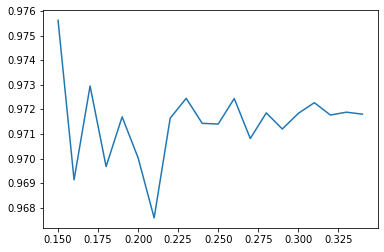

In [ ]:
import matplotlib.pyplot as plt
list(scores.keys())
plt.plot(list(scores.keys()),list(scores.values()))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_reduced_scale, training_reduced.Y, test_size=0.15)

### Random forest 

In [ ]:
RF =  RandomForestClassifier(n_estimators= 1000, min_samples_leaf= 1, min_samples_split= 2)
RF.fit(W_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
RF.score(W_test, y_test)

0.875609190067301

Feature: 0, Score: 0.00537
Feature: 1, Score: 0.02672
Feature: 2, Score: 0.00577
Feature: 3, Score: 0.00806
Feature: 4, Score: 0.00263
Feature: 5, Score: 0.00420
Feature: 6, Score: 0.01872
Feature: 7, Score: 0.03665
Feature: 8, Score: 0.00858
Feature: 9, Score: 0.00923
Feature: 10, Score: 0.02914
Feature: 11, Score: 0.00151
Feature: 12, Score: 0.00257
Feature: 13, Score: 0.00617
Feature: 14, Score: 0.00674
Feature: 15, Score: 0.07153
Feature: 16, Score: 0.01232
Feature: 17, Score: 0.10831
Feature: 18, Score: 0.21048
Feature: 19, Score: 0.00644
Feature: 20, Score: 0.02001
Feature: 21, Score: 0.07267
Feature: 22, Score: 0.04958
Feature: 23, Score: 0.00481
Feature: 24, Score: 0.00615
Feature: 25, Score: 0.01237
Feature: 26, Score: 0.00850
Feature: 27, Score: 0.24477


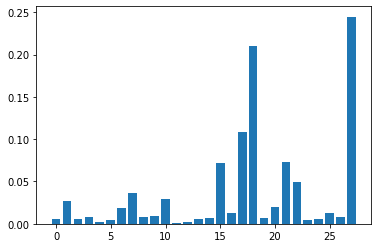

In [ ]:
import matplotlib.pyplot as plt

# get importance
importance = RF.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# get importance
importance = RF.feature_importances_
L_importance = []
# summarize feature importance
for i,v in enumerate(importance):
    if v >= 0.02:
        L_importance.append(i)
	  #print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
X_train_bis = X_train[L_importance]
X_test_bis = X_test[L_importance]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents_train = pca.fit_transform(X_train)
principalComponents_test = pca.fit_transform(X_test)

In [ ]:
from sklearn.decomposition import NMF
model_nmf = NMF(n_components=15, init='random', random_state=0)
W_train = model_nmf.fit_transform(X_train)
W_test = model_nmf.fit_transform(X_test)

In [ ]:
#hyperparameter grid search for randomforest
n_estimators = [1000,1500]
max_depth = [5,10,15]
min_samples_split = [2,3,4]
min_samples_leaf = [1,2,5]

from sklearn.model_selection import GridSearchCV

hyperF = dict(n_estimators = n_estimators, 
              min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf)
clf = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 10,
                      n_jobs = -1, scoring='f1_weighted')

clf.fit(X_train, y_train)
clf_best = clf.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 61.8min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 71.8min finished


In [ ]:
clf_best.score(X_test,y_test)

0.9722199658841686

In [ ]:
clf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf_best, X_train, y_train, cv=3)

In [ ]:
clf_best.score(X_test, y_test)

0.9733116732420515

### Logistic regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.param_grid

{'min_samples_leaf': [1, 2, 3, 6],
 'min_samples_split': [2, 3, 4, 6],
 'n_estimators': [100, 200, 400, 600, 800, 1000]}

In [ ]:
#hyperparameter grid search for logisticregression
tolerance = [1e-7, 1e-6, 1e-5]
max_iter = [100, 200, 300, 400]
regularization = [0.75, 0.9, 1]

from sklearn.model_selection import GridSearchCV

hyperLR = dict(tol = tolerance, 
              max_iter = max_iter,
             C = regularization)
lr = GridSearchCV(LogisticRegression(), hyperLR, cv = 4, verbose = 1,
                      n_jobs = -1, scoring='accuracy')

lr.fit(X_train, y_train)
lr_best = lr.best_estimator_

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   41.6s finished


In [ ]:
lr_best

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-07, verbose=0,
                   warm_start=False)

In [ ]:
lr_best.score(X_test, y_test)

0.942441590592604

### XG Boost

In [ ]:
#hyperparameter grid search for randomforest
n_estimators = [200, 400, 600, 800, 1000]
max_depth = [5, 10, 15]
min_samples_split = [2,4,6]
min_samples_leaf = [1, 3, 6]

from sklearn.model_selection import GridSearchCV

hyperF = dict(n_estimators = n_estimators, 
              min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf)
xgb = GridSearchCV(XGBClassifier(), hyperF, cv = 5, verbose = 1,
                      n_jobs = -1, scoring='accuracy')

xgb.fit(X_train, y_train)
xgb_best = xgb.best_estimator_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 58.4min finished


In [ ]:
xgb_best.score(X_test, y_test)

0.9750889679715302

In [ ]:
xgb= XGBClassifier(n_estimators=1000)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Decision Tree

In [ ]:
#hyperparameter grid search for randomforest
from sklearn.model_selection import GridSearchCV

hyperF = dict(n_estimators = n_estimators, 
              min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf)
dt = GridSearchCV(DecisionTreeClassifier(), hyperF, cv = 3, verbose = 1,
                      n_jobs = -1, scoring='accuracy')

dt.fit(X_test, y_test)
dt_best = dt.best_estimator_

In [ ]:
dt.score(X_test, y_test)

0.9610118356927362

In [ ]:
dt= DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### SVC

In [ ]:

svc= SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc.score(X_test, y_test)

0.9591552564400093

In [ ]:
lsvc= LinearSVC()
lsvc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
lsvc.score(X_test, y_test)

0.9589231840334185

### Extra Trees

In [ ]:
et=ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
et.score(X_test, y_test)

0.9729635646321653

### Gradient boosting

In [ ]:
gb=GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
gb.score(X_test, y_test)

0.9745880714783012

### AdaBoost

In [ ]:
ab=AdaBoostClassifier(n_estimators=1000, learning_rate=0.8)
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=1000, random_state=None)

In [ ]:
ab.score(X_test, y_test)

0.9707588767695521

In [ ]:
from sklearn.model_selection import GridSearchCV

ada=AdaBoostClassifier()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.1,0.3,.5]}
search=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='f1_micro',cv=3,verbose=10)

In [ ]:
search.fit(X_train,y_train)
clf_best = search.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.001, n_estimators=500, score=0.960, total=  25.1s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.958, total=  25.1s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.2s remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=500, score=0.956, total=  25.1s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.960, total=  50.3s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.958, total=  50.0s
[CV] learning_rate=0.001, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=1000, score=0.957, total=  50.0s
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.8min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.963, total= 1.7min
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.5min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.959, total= 1.7min
[CV] learning_rate=0.001, n_estimators=2000 ..........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.1min remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=2000, score=0.959, total= 1.6min
[CV] learning_rate=0.01, n_estimators=500 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.8min remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=500, score=0.966, total=  24.9s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV]  learning_rate=0.01, n_estimators=500, score=0.962, total=  24.9s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV]  learning_rate=0.01, n_estimators=500, score=0.962, total=  24.8s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=0.971, total=  49.5s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=0.968, total=  49.4s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[CV]  learning_rate=0.01, n_estimators=1000, score=0.967, total=  49.4s
[CV] learning_rate=0.01, n_estimators=2000 ...........................
[CV]  learning_rate=0.01, n_estimators=2000, score=0.973, total= 1.6min
[CV] learning_rate=0.01, n_estimators=2000 ...........................
[C

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 26.1min finished


In [ ]:
clf_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=2000, random_state=None)

### Stacking

In [ ]:
#stacking classifiers

base_learners = [
              #   ('lr', LogisticRegression()),
                 ('xgb', xgb_best),
                 ('rf', clf_best)
                     
                ]
stc = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
stc.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1,
                                              min_samples_leaf=1,
                                              min_samples_split=2, missing=None,
                                              n_estimators=400, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_...
                        

In [ ]:
stc.score(X_test, y_test)

0.9785333023903457

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp.score(X_test,y_test)

0.9720575095443099

In [ ]:
from sklearn.metrics import f1_score
mlp.f1_score(X_test,y_test)

AttributeError: ignored

In [ ]:
mlp = MLPClassifier(activation='relu', alpha=1e-05, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp.score(X_test,y_test)

0.9714550939893246

In [ ]:
mlp = MLPClassifier(activation='relu', alpha=1e-06, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-06, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp.score(X_test,y_test)

0.973032247583462

In [ ]:
#hyperparameter grid search for randomforest
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV

learning_rate_init = [1e-3, 1e-2,1e-4]
alpha = [1e-5, 1e-4,1e-6]
hidden_layer_sizes = [200,400,600,800]
activation= ['tanh', 'relu']
solver=['sgd', 'adam']



hypermlp = dict(learning_rate_init = learning_rate_init,
                alpha = alpha,
                hidden_layer_sizes = hidden_layer_sizes,
                activation = activation,
                solver = solver)

    
mlp = GridSearchCV(MLPClassifier(random_state=1, max_iter=300), hypermlp, cv = 3, verbose = 10,
                      n_jobs = -1, scoring='f1_weighted')

mlp.fit(X_test, y_test)
mlp_best = mlp.best_estimator_

NameError: ignored

In [ ]:
mlp_best

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=600, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp_best.score(X_test, y_test)

0.9743312032925376

In [ ]:
mlp=MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[200,200], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

NameError: ignored

In [ ]:
mlp.fit(X_train,y_train)
mlp.score(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9684826167009639

### Gaussian process classifier

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [ ]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)
gpc.fit(X_train, y_train)

In [ ]:
gpc.score(X_test, y_test)

NameError: ignored

### Gaussian NB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
gnb.score(X_test, y_test)

0.9448828034346716

### Quadratic discriminant analysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [ ]:
qda.score(X_test, y_test)

0.9454629844511487

### K neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
neigh.score(X_test, y_test)

0.9270132281271757

# Output

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_best = MLPClassifier(activation='relu', alpha=1e-07, batch_size=140, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=800,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

clf.fit(X_train, y_train)


In [ ]:

#writing predictions to csv

predictions = list(clf_best.predict(testing_scale))
pred_df = pd.DataFrame(predictions,columns =['category'])
pred_df.index.names = ['id']
#pred_df.to_csv('predictions_RFgridsearch_fullfeatures_scaled.csv')

In [ ]:
pred_df.to_csv(path+'predictions_mlp.csv')